# Renewable Energy Sources - APP CSP
<i><u>Author</u> : Anthony CHUNG (25881800) - Louis GOUDERS </i>

## Context 
An agro-food industry established in the South of Spain, near Granada, would like to produce its own energy, in order to meet both its electricity and heat needs.

Hired as an energy efficiency engineer, we are asked to investigate the possibility of building a CSP plant, that should be designed to avoid injecting electricity on the grid to maximize the ROI. 

Additionally, we are also asked to think  about management of the production during the night so that the factory does not stop running, but still runs at a capacity factor of minimum 30% of the design baseload.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data

The city of Granada is located in Spain with the latitude 37.17 and the longitude -3.58.  
The data for the year 2019 is provided by the The National Solar Radiation Database (NSRDB). The granularity of the dataset is set to 30 minutes and here's below a list of the informations given : 

Meteorological data:
- Half-hourly irradiance DHI [W/m2]
- Half-hourly irradiance DNI [W/m2]
- Half-hourly irradiance GHI [W/m2]
- Drew point [°C]
- Temperature (dry bulb) [Celsius]
- Pressure [mbar]
- Relative Humidity [%]
- Wind direction [deg]
- Wind speed [m/s]


In [8]:
#CSV files
df_granada = pd.read_csv('Granada_msg-iodc_30_2019.csv',header = 2, usecols =  [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])
df_granada.head()

#Extract the period of interest
# Index of first day of August
idx_start = df_granada.index[df_granada['Month'] == 8][0]
# Index of first day of October
idx_last = df_granada.index[df_granada['Month'] == 10][-1]
df2_granada = df_granada[idx_start:idx_last+1]
df2_granada.tail()
print(df2_granada.shape)

(4416, 18)


Text(0.5, 0, 'time [half hours]')

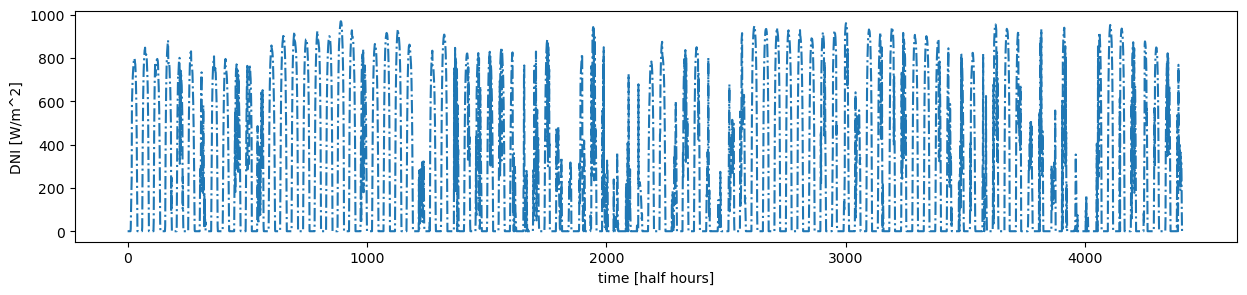

In [51]:
time = np.arange(len(df2_granada))
DNI = df2_granada['DNI']      
# DHI = df2_granada['DHI']    
# GHI = df2_granada['GHI']     


plt.figure(figsize = (15,3))
plt.plot(time, DNI,'-.')
plt.ylabel('DNI [W/m^2]')
plt.xlabel('time [half hours]')

# plt.figure(figsize = (15,3))
# plt.plot(time, DHI,'-.')
# plt.ylabel('DHI [W/m^2]')
# plt.xlabel('time [half hours]')

# plt.figure(figsize = (15,3))
# plt.plot(time, GHI,'-.')
# plt.ylabel('GHI [W/m^2]')
# plt.xlabel('time [half hours]')
# plt.show()

# Solar field 

In order to compute the size of the solar field, we will need to compute the aperture area as well as defining a distance between the collector rows.
It has been showned that the formula for the rough approximation of the aperture area given below is a good representation of existang power plants.

\begin{aligned}
    A_{ap} = \frac{P_{el} \cdot SM}{\eta \cdot G_{b,ap}}
\end{aligned}
where 
- $P_{el}$ is the rated electric power 
- $SM$ is the solar multiple 
- $\eta$ is the solar-to-electric efficiency
- $G_{b,ap}$ is the solar-to-electric efficiency

**Rated electric power**

Given that we need to cover the needs the installation which are $90\ kWh_e/t_{sugar}$ and that we processes $14 000$ tons of sugar-beets per day, we need a capacity of $\frac{90 \cdot 14000}{24} = 52.5\ MW$. 
This value falls between the usual range of capacity for CSP of $30$ to $80\ MW$

**Solar mMultiple**

#TODO

**Solar-to-electric efficiency**

*Optical losses*

#TODO

*Thermal losses*

#TODO

**Direct irradiance**

In order to dimension the aperture area, we need to define a rederence irradiance value to be a design point. Several choices can be considered such as the peak irradiance or a weak irradiance, but both choices have their pros and cons
- If we choose a high direct irradiance, then the power block is nearly always operated under part-load conditions, which reduces the power block efficiency
- If we choose a low direct irradiance, then the solar field gets very large, which raises the investment costs and it will happen more frequently that thermal energy from the solar field cannot be used in the power block and has to be dumped

According to the textbook : *"Simulations concerning a specific 50MW plant in southern Spain rendered the result that the optimal design direct collector irradiance corresponds to the value that has a frequency distribution of 55-60%, which for the considered location was at 650-700W/m². The frequency distribution means that at 55-60% of the periods, when direct radiation is available, the direct radiation on the collector aperture reaches this value or is higher."*

Since our installation will also be located in the South of Spain and the we have a quite similar capacity, we will compute the direct irradiance that has a frequency distribution of 55-60% for our database.

In [52]:
DNI_range = np.arange(50, 1050, 50)
DNI_lenna = np.count_nonzero(DNI)
lb_DNI = 0
UB_DNI = 0
DNI_count = dict.fromkeys(DNI_range, 0)
for i in DNI : 
    for j in DNI_range :
        if i>= j:
            DNI_count[j] += 1
        
for (i,j) in DNI_count.items():
    DNI_count[i] = j/DNI_lenna*100
    if DNI_count[i] > 54.5 and DNI_count[i] < 55.5:
        ub_DNI = i
    if DNI_count[i] < 61.5 and DNI_count[i] > 59.5:
        lb_DNI = i

print(DNI_count)
print("Frequency distribution of direct irradiance : ")
for (i,j) in DNI_count.items():
    print("    ",i, "W/m² :", round(j,1) ,"%")

print("Optimal direct irradiance for design point : [", lb_DNI,",", ub_DNI,"]" , "W/m²")

{50: 95.21507974867085, 100: 91.39681005316578, 150: 88.06186563557274, 200: 84.29192846785887, 250: 79.1203479942001, 300: 73.94876752054132, 350: 69.4055099081682, 400: 65.3455775737071, 450: 61.18898018366361, 500: 57.90236829386177, 550: 54.90575157080715, 600: 51.135814403093285, 650: 47.849202513291445, 700: 42.96761720637989, 750: 36.24939584340261, 800: 27.114548090865153, 850: 17.593040115998065, 900: 7.829869502174963, 950: 0.7733204446592556, 1000: 0.0}
Frequency distribution of direct irradiance : 
     50 W/m² : 95.2 %
     100 W/m² : 91.4 %
     150 W/m² : 88.1 %
     200 W/m² : 84.3 %
     250 W/m² : 79.1 %
     300 W/m² : 73.9 %
     350 W/m² : 69.4 %
     400 W/m² : 65.3 %
     450 W/m² : 61.2 %
     500 W/m² : 57.9 %
     550 W/m² : 54.9 %
     600 W/m² : 51.1 %
     650 W/m² : 47.8 %
     700 W/m² : 43.0 %
     750 W/m² : 36.2 %
     800 W/m² : 27.1 %
     850 W/m² : 17.6 %
     900 W/m² : 7.8 %
     950 W/m² : 0.8 %
     1000 W/m² : 0.0 %
Optimal direct irradiance f

From the calculation, we observe that the optimal direct irradiance falling the in frequency distribution of 55-60% is around $[450,550]\ W/m²$, which is again close the the texbook simulations. 
We decide to choose the average value as design point.

**Aperture Area**

From here, we can compute the approximation of the aperture area given by the formula : 
\begin{aligned}
    A_{ap} = \frac{P_{el} \cdot SM}{\eta \cdot G_{b,ap}}
\end{aligned}
where 
- $P_{el} = 52.5\ MW$
- $SM = $ 
- $\eta = $ 
- $G_{b,ap} = 500\ W/m²$

In [50]:
DNI_design = (ub_DNI + lb_DNI)/2 
A = (52.5*10**6)/(DNI_design*0.14)
print(A,"[m2] =",A/(10**6),"km2")

750000.0 [m2] = 0.75 km2


The approximation gives us a aperture area of 0.75 km². If we make the assumption that between

Since the solar fied is composed of rows of collectors loops with a certain arragement around the power block, we need to take into account the distance between the collector loops as well as the size of the collector itself in order to compute the size of the solar field.

From the texbook, the aperture width and module length of most actual collectors are 6m and 12m respectively.
Thus, we need around $\frac{750000}{6 \cdot 12} = 10417$ collectors

Considering that solar fields are composed of rows of collectors loops of length of about two times 300m, we can have 25 collectors per row or 50 collectors per loop.

In terms of number of loops, we need $\frac{10417}{50} = 208.34$ collectors loops

Since most CSP field are composed of columns of around 40 loops, we can imagine a plant composed of around $\frac{208}{40} = 5.2$ columns

If we make the assumption that between each collectors loops and between the two branches of a loops, there a distance of 12m, the width of two collectors. Then we can expect a ground area of 
$750000 + (208 \cdot 2 \cdot 12 \cdot 300) = 2247600\ m² = 2.2476\ km²$